In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict

In [2]:
df1 = pd.read_csv('datatraining.txt', header=0, parse_dates=[0], index_col=0, squeeze=True)
df2= pd.read_csv('datatest.txt', header=0, parse_dates=[0], index_col=0, squeeze=True)
df3= pd.read_csv('datatest2.txt', header=0, parse_dates=[0], index_col=0, squeeze=True)

df4= pd.merge(df2, df1, how='outer')
df_m=pd.merge(df4, df3, how='outer')

df = df_m.set_index(['date'])


In [3]:
from data_preparation import prepare_dataset

In [4]:
class_name = 'Occupancy'
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1


In [5]:
X = np.zeros(shape=(20,50))

for i in range(20):
    X[i] = np.array(df['CO2'].sample(n=50))
    

In [6]:
X.shape

(20, 50)

## Clustering

Shape-Based Clustering

In [8]:
from tslearn.clustering import TimeSeriesKMeans

C:\Users\Gianmarco\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


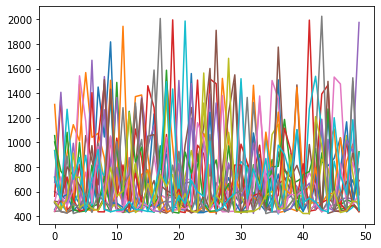

In [9]:
plt.plot(X.reshape(X.shape[1], X.shape[0]))
plt.show()

In [33]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km.fit(X)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=5,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=3, n_init=1, n_jobs=None,
                 random_state=0, tol=1e-06, verbose=0)

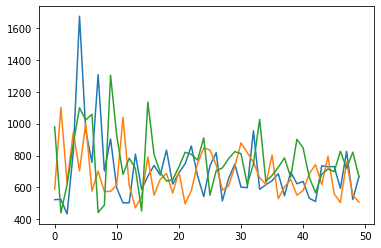

In [34]:
plt.plot(km.cluster_centers_.reshape(X.shape[1], 3))
plt.show()

In [35]:
km.labels_

array([2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 0, 1, 0, 2, 1, 1, 1, 1],
      dtype=int64)

In [36]:
km.inertia_

4074247.5464565977

In [37]:
km_dtw = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=5, random_state=0)
km_dtw.fit(X)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=5,
                 max_iter_barycenter=100, metric='dtw', metric_params=None,
                 n_clusters=3, n_init=1, n_jobs=None, random_state=0, tol=1e-06,
                 verbose=0)

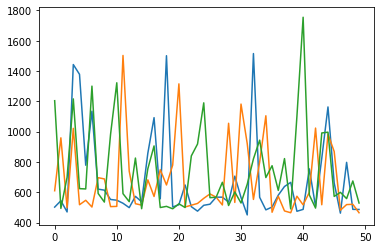

In [38]:
plt.plot(km_dtw.cluster_centers_.reshape(X.shape[1], 3))
plt.show()

In [39]:
km_dtw.labels_

array([0, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1, 1, 0, 2, 0, 2, 1, 0, 1, 1],
      dtype=int64)

In [40]:
km_dtw.inertia_

1179849.1595957333

N.B : con dtw distance l'inertia si abbassa 

Features-based Clustering

In [33]:
from sklearn.cluster import KMeans
import scipy.stats as stats

In [34]:
def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

In [35]:
F = [list(calculate_features(x).values())[:-2] for x in X]

In [38]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(F)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [39]:
kmeans.inertia_

1533703577.456986

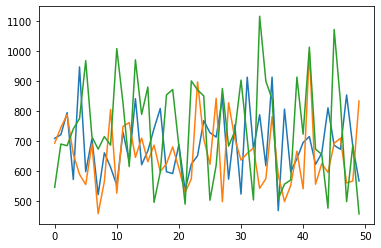

In [40]:
for i in range(3):
    plt.plot(np.mean(X[np.where(kmeans.labels_ == i)[0]], axis=0))
plt.show()

Compression-based Clustering

In [47]:
from sklearn.metrics import pairwise_distances
import zlib
import string

In [48]:
def cdm_dist(x, y):
    x_str = (' '.join([str(v) for v in x.ravel()])).encode('utf-8')
    y_str = (' '.join([str(v) for v in y.ravel()])).encode('utf-8')
    return len(zlib.compress(x_str + y_str)) / (len(zlib.compress(x_str)) + len(zlib.compress(y_str)))

In [49]:
M = pairwise_distances(X.reshape(X.shape[0], X.shape[1]), metric=cdm_dist)

In [50]:
M.shape

(20, 20)

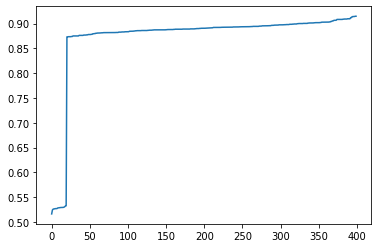

In [51]:
plt.plot(sorted(M.ravel()))
plt.show()

In [52]:
from sklearn.cluster import DBSCAN

In [59]:
dbscan = DBSCAN(eps=0.875, min_samples=3, metric='precomputed')
dbscan.fit(M)

DBSCAN(algorithm='auto', eps=0.875, leaf_size=30, metric='precomputed',
       metric_params=None, min_samples=3, n_jobs=None, p=None)

In [60]:
dbscan.labels_

array([ 0,  0, -1,  0, -1,  0, -1,  0, -1, -1, -1, -1,  0, -1, -1,  0,  0,
       -1, -1,  0], dtype=int64)

Approximated Clustering

In [10]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

In [11]:
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
X_paa = paa.fit_transform(X)

n_sax_symbols = 30
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
X_sax = sax.fit_transform(X)

n_sax_symbols_avg = 6
n_sax_symbols_slope = 3
one_d_sax = OneD_SymbolicAggregateApproximation(
    n_segments=n_paa_segments,
    alphabet_size_avg=n_sax_symbols_avg,
    alphabet_size_slope=n_sax_symbols_slope)
X_1d =one_d_sax.fit_transform(X)

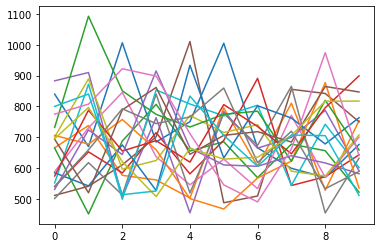

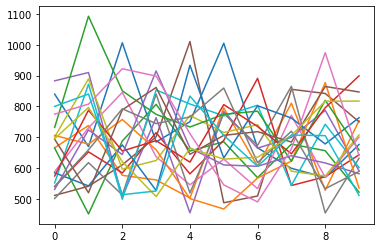

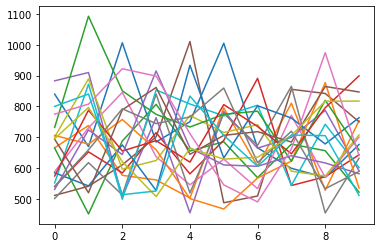

In [12]:
plt.plot(X_paa.reshape(X_paa.shape[1], X_paa.shape[0]))
plt.show()

plt.plot(X_paa.reshape(X_sax.shape[1], X_sax.shape[0]))
plt.show()

plt.plot(X_paa.reshape(X_1d.shape[1], X_1d.shape[0]))
plt.show()

In [13]:
km_paa = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km_paa.fit(X_paa)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=5,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=3, n_init=1, n_jobs=None,
                 random_state=0, tol=1e-06, verbose=0)

In [14]:
km_sax = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km_sax.fit(X_sax)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=5,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=3, n_init=1, n_jobs=None,
                 random_state=0, tol=1e-06, verbose=0)

In [15]:
km_1d = TimeSeriesKMeans(n_clusters=3, metric="euclidean", max_iter=5, random_state=0)
km_1d.fit(X_1d)

TimeSeriesKMeans(dtw_inertia=False, init='k-means++', max_iter=5,
                 max_iter_barycenter=100, metric='euclidean',
                 metric_params=None, n_clusters=3, n_init=1, n_jobs=None,
                 random_state=0, tol=1e-06, verbose=0)

In [17]:
print(km_paa.inertia_,km_sax.inertia_,km_1d.inertia_)

123014.64545463628 inf 7.011111111111111


In [18]:
#miglior risultato con 1d_sax, con sax mi viene sempre infinito

In [19]:
km_paa.labels_

array([0, 1, 0, 2, 1, 1, 2, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 1, 0, 0],
      dtype=int64)

In [20]:
km_1d.labels_

array([1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 2, 0, 1, 1, 0, 1, 0, 1, 2],
      dtype=int64)

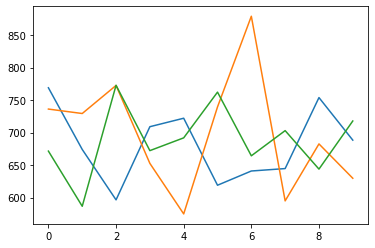

In [21]:
for i in range(3):
    plt.plot(np.mean(X_paa[np.where(km_paa.labels_ == i)[0]], axis=0))
plt.show()

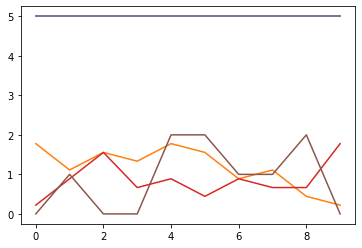

In [32]:
for i in range(3):
    plt.plot(np.mean(X_1d[np.where(km_1d.labels_ == i)[0]], axis=0))
plt.show()